In [1]:
# !pip install -r requirements.txt

In [2]:
#|default_exp train

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [4]:
#|export
import torch, torch.nn.functional as F, random, wandb, time, contextlib
import torchvision.transforms as T
import torch.distributed as dist
import bitsandbytes as bnb
from torchvision import transforms
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed, get_constant_schedule_with_warmup
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from functools import partial
from types import SimpleNamespace
from statistics import mean

from utils import (
    generate,
    plot_density, 
    pil_add_text, 
    latent_to_PIL, 
    make_grid, 
    encode_prompt, 
    dcae_scalingf, 
    pil_clipscore, 
    free_memory, 
    get_rnd_sigmas,
    get_sigma_schedule,
    load_imagenet_1k_vl_enriched_recaped,
)

from utils_datasets import (
   ShapeBatchingDataset,
)

seed = 42
set_seed(seed)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [6]:
#|export
dtype = torch.bfloat16
device = "cuda" 
debug = True
ddp = True

model_config = SimpleNamespace(
    text_encoder = "HuggingFaceTB/SmolLM2-360M",
    transformer_from = "transformer_Sana-DiT-XL-smollm2.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
)

data_config = SimpleNamespace(
    dataset = "g-ronimo/IN1k256-bfl16latents_shape_dc-ae-f32c32-sana-1.0",
    col_label = "label",
    col_latent = "latent",
    split_train = "train",
    split_eval = "validation",
)

train_config = SimpleNamespace(
    version = "alpha44",
    lr = 4e-4,
    bs = 256,
    gradient_accumulation_steps = 1,
    epochs = 100,
    resume_from_step = None,
    lr_scheduler = torch.optim.lr_scheduler.LinearLR,
    lr_scheduler_args = dict(
        start_factor=1.0, 
        end_factor=0.25, 
        total_iters=50_000,
    ),
    # steps_warmup = None,
    steps_log = 10,
    steps_eval = 1300,
    epochs_save = 1,
    timesteps_training = 1000,
    sigma_sampling = "normal",  # beta uniform normal
    grad_checkpointing = True,
    log_wandb = True,
    wandb_project = "Hana",
    wandb_run = "{version}-{size:.2f}M_LR-{lr}_BS-{bs}_GAS-{gas}_{ws}x{device}",
)

eval_config = SimpleNamespace(
    prompts = [
        "a collection of comic books on a table",
        "a green plant with a green stem",
        "an airplane in the sky",
        "two fighter jets on the red sky",
        "a blonde girl",
        "a red car",
        "a blue car",
        "a cheeseburger on a white plate", 
        "a bunch of bananas on a wooden table", 
        "a white tea pot on a wooden table", 
        "an erupting volcano with lava pouring out",
    ],
    seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    inference_config = dict(
        num_steps = 20, 
        guidance_scale = 7,
        latent_dim = [1, 32, 8, 8]  # 128x128px
    )
)

In [7]:
#|export
def load_models(text_encoder, transformer_repo, ae, dtype, device):
    if ".json" in transformer_repo:
        transformer = SanaTransformer2DModel.from_config(transformer_repo).to(device).to(dtype)
    else:
        transformer = SanaTransformer2DModel.from_pretrained(transformer_repo).to(device).to(dtype)

    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def add_random_noise(latents, dist, timesteps=1000):
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    sigmas = get_rnd_sigmas(bs, dist=dist).to(latents.device)  # floats 0-1 of dist specified in train_config
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, `timesteps = sigmas * 1000`, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), noise, timesteps

def eval_loss(dataloader_eval, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist=train_config.sigma_sampling)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        # stop if testing or 1 epoch complete
        if testing or batch_num>len(dataloader_eval): break
    return sum(losses)/len(losses)

In [8]:
# DON'T EXPORT
ddp = False

In [9]:
#|export
if ddp:
    dist.init_process_group(backend='nccl')
    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    debug = debug and is_master
else:
    # Running on single GPU or in notebook
    is_master = True
    world_size = 1
    local_rank = 0

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = model_config.text_encoder,
    transformer_repo = model_config.transformer_from,
    ae = model_config.ae,
    dtype = dtype,
    device = device
)

if "SmolLM2" in model_config.text_encoder: tokenizer.pad_token = tokenizer.eos_token
if train_config.grad_checkpointing: transformer.enable_gradient_checkpointing()
if ddp: transformer = DistributedDataParallel(transformer, device_ids=[local_rank])

ds = load_dataset(data_config.dataset)
dataloader_train = ShapeBatchingDataset(
    ds[data_config.split_train], text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=ddp,
)
dataloader_eval = ShapeBatchingDataset(
    # ddp = false, we want a random sampler, not the distributed samples, in any case
    ds[data_config.split_eval], text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=False
)

optimizer = bnb.optim.AdamW8bit(transformer.parameters(), lr=train_config.lr)
lr_scheduler = train_config.lr_scheduler(optimizer, **train_config.lr_scheduler_args)

wandb_run = train_config.wandb_run.format(
    version=train_config.version,
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    gas=train_config.gradient_accumulation_steps,
    ws=world_size,
    device=device,
)

# num_batches / batches per step
steps_epoch = len(dataloader_train)  // train_config.gradient_accumulation_steps
if is_master: print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Transformer parameters: 590.20M
DCAE parameters: 312.25M


Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

steps per epoch: 5004


Sigma distribution:


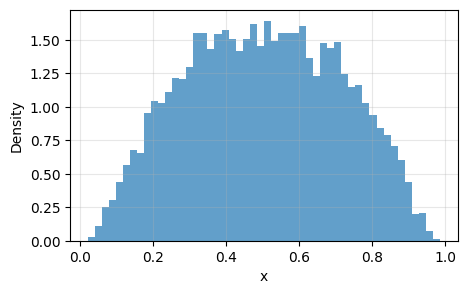

Testing noising:


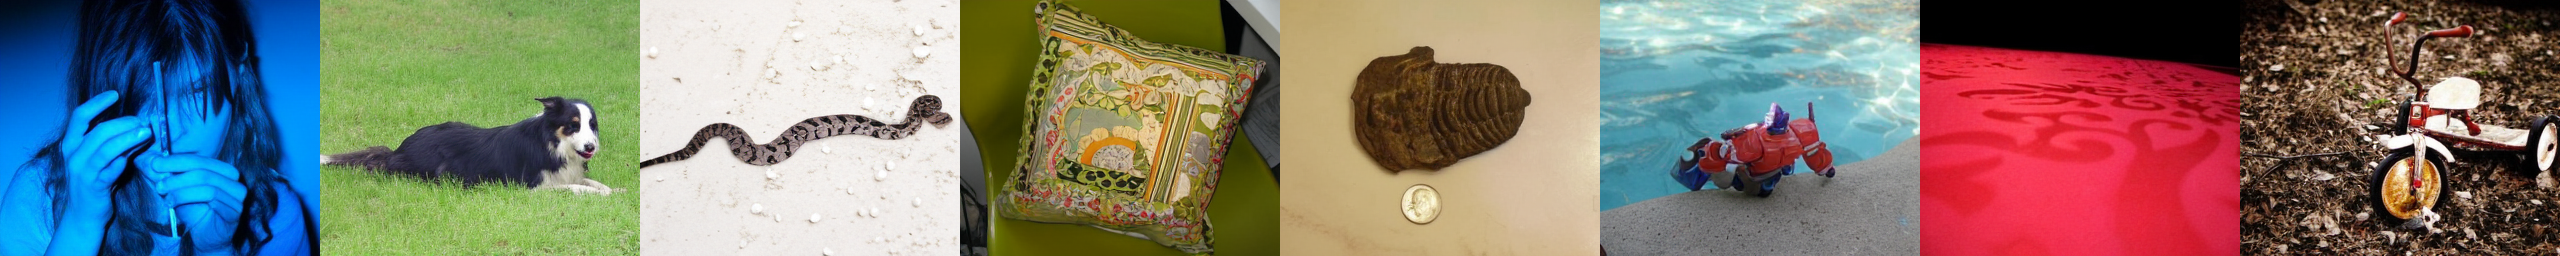

timesteps rounded [190, 869, 303, 578, 408, 312, 317, 150]


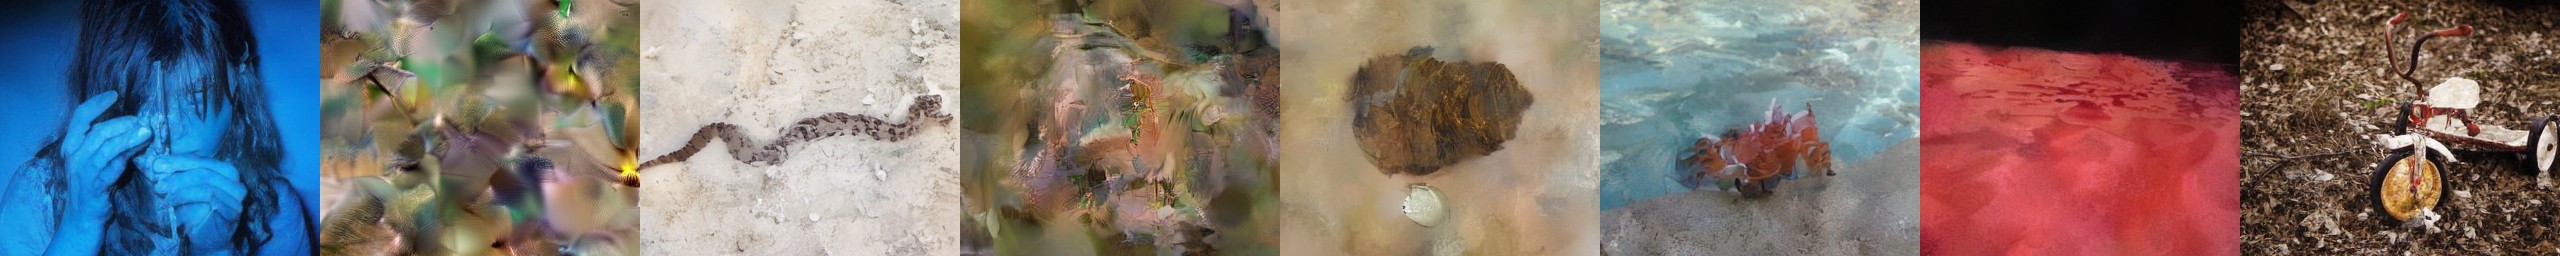

Eval prompts:
[(0, 'a collection of comic books on a table'), (1, 'a green plant with a green stem'), (2, 'an airplane in the sky'), (3, 'two fighter jets on the red sky'), (4, 'a blonde girl'), (5, 'a red car'), (6, 'a blue car'), (7, 'a cheeseburger on a white plate'), (8, 'a bunch of bananas on a wooden table'), (9, 'a white tea pot on a wooden table'), (10, 'an erupting volcano with lava pouring out')]
Inspecting first batch


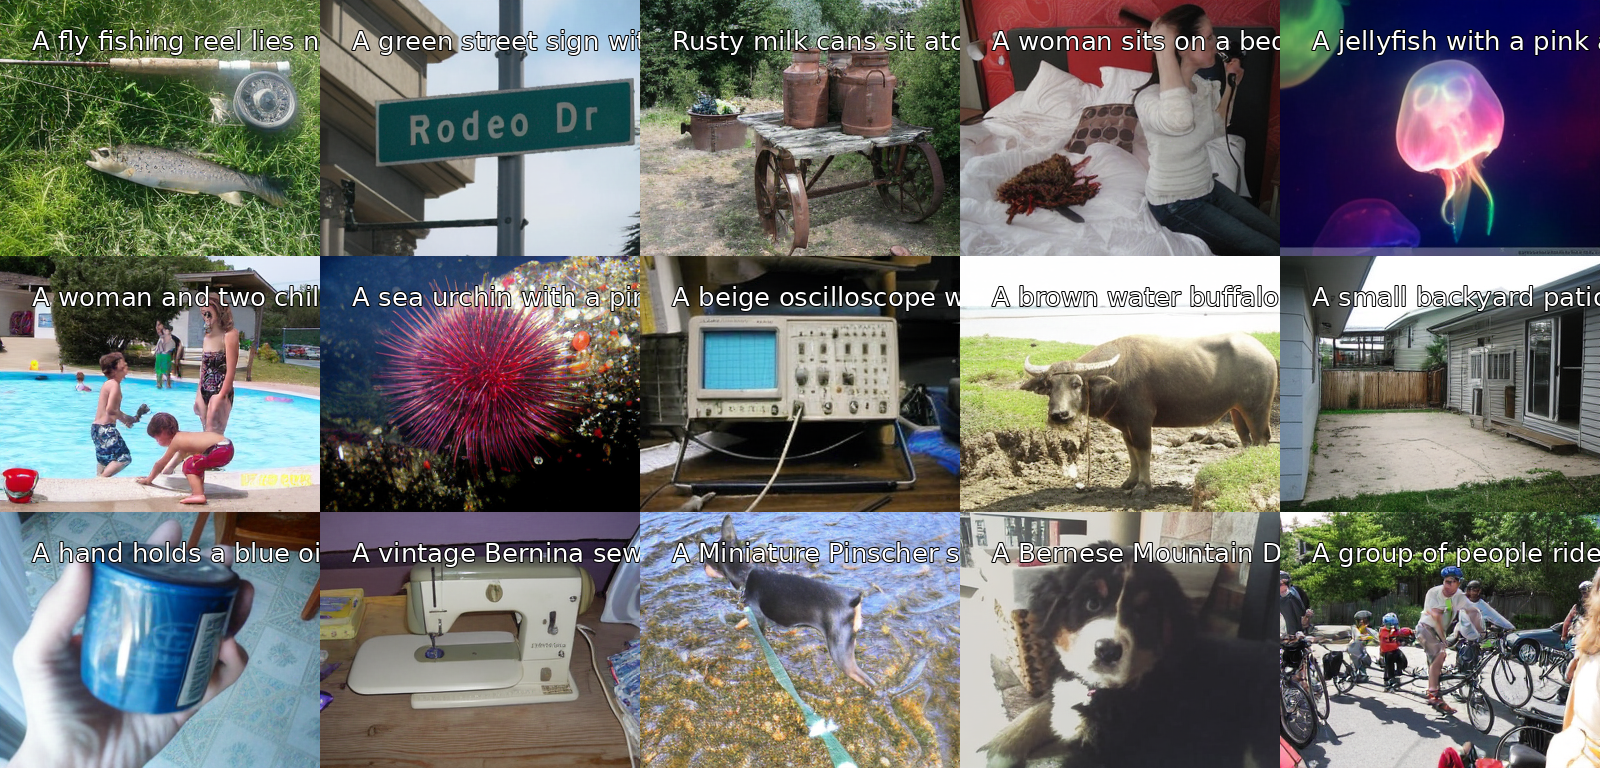

Testing generate


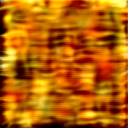

Testing eval loss


eval_loss: 0it [00:02, ?it/s]


2.328125
Testing eval images and clip score


eval_images: 100%|██████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


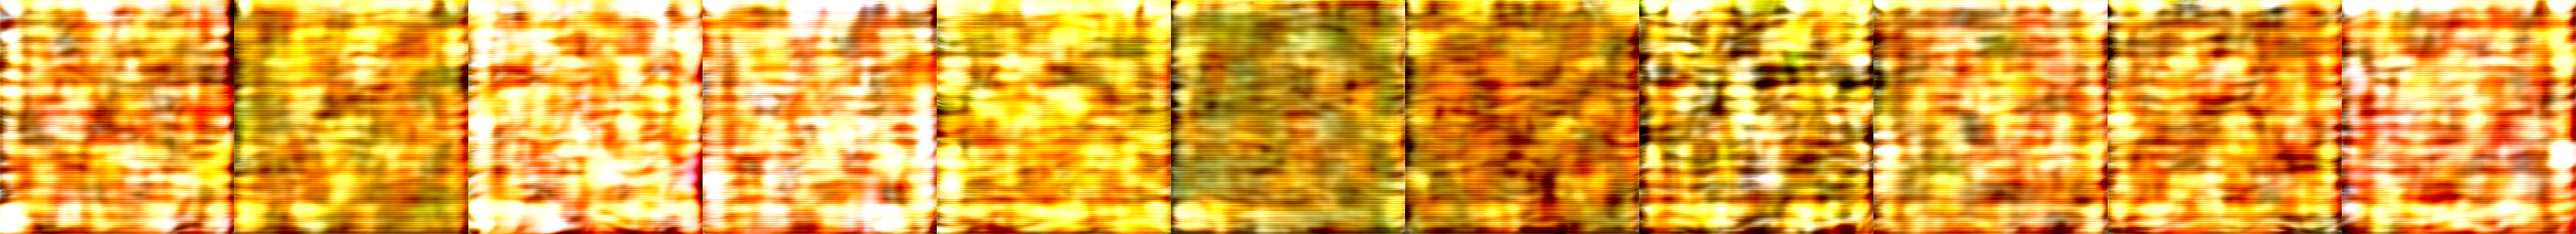

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


21.728906631469727


In [10]:
# DONT EXPORT
if is_master: 
    print("Sigma distribution:")
    sigmas = get_rnd_sigmas(10_000, train_config.sigma_sampling)
    plot_density(sigmas)

    print("Testing noising:")
    def test_noising():
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
        # latents=latents.to(dtype).to(device)
        latent=latents[0:8,:] * dcae_scalingf
        display(make_grid(latent_to_PIL(latent / dcae_scalingf,dcae)))
        
        latent_noisy, noise, timesteps = add_random_noise(latent, dist=train_config.sigma_sampling)
        
        print("timesteps rounded", list(map(round, timesteps.tolist())))
        display(make_grid(latent_to_PIL(latent_noisy / dcae_scalingf,dcae)))
    test_noising()

    print("Eval prompts:")
    print(list(enumerate(eval_config.prompts)))
    
    print("Inspecting first batch")
    def show_first_batch(dataloader):
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
        # latents=latents.to(dtype).to(device)
        images = [pil_add_text(latent_to_PIL(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
        display(make_grid(images[:15], 3, 5))
    show_first_batch(dataloader_train)
    
    print("Testing generate")
    display(generate("horse", transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config).resize((128,128)))
    
    print("Testing eval loss")
    print(eval_loss(dataloader_eval, testing=True))
    
    print("Testing eval images and clip score")
    images = [
        generate(p, transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config) 
        for p in tqdm(eval_config.prompts, "eval_images")
    ]
    display(make_grid(images))
    print(pil_clipscore(images, eval_config.prompts))

# Train

In [1]:
import nbdev; nbdev.export.nb_export(__session__)

In [12]:
#|export

if is_master and train_config.log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(
        project=train_config.wandb_project, 
        name=wandb_run
    ).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

last_step_time = time.time()
step = train_config.resume_from_step if train_config.resume_from_step is not None else 0
step_loss, sample_count, last_sample_count = 0, 0, 0
time_dataload, time_dataload_start = 0, time.time()
free_memory()

for batch_idx, (labels, latents, prompts_encoded, prompts_atnmask) in enumerate(dataloader_train):  
    time_dataload += time.time() - time_dataload_start

    if ddp and train_config.gradient_accumulation_steps > 1 and batch_idx % train_config.gradient_accumulation_steps != 0:
        # no_sync when accumulating gradients locally
        context = transformer.no_sync()
    else:
        context = contextlib.nullcontext()

    latents = latents * dcae_scalingf
    latents_noisy, noise, t = add_random_noise(latents, dist = train_config.sigma_sampling)

    with context:
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(noise_pred, noise - latents)        
        loss = loss / train_config.gradient_accumulation_steps
        loss.backward()

        step_loss += loss.cpu().detach().item() 
        sample_count += len(labels)

    if batch_idx % train_config.gradient_accumulation_steps == 0:
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()

        step += 1
        epoch = step / steps_epoch

        # Log step
        if is_master and step>0 and step % train_config.steps_log == 0:
            step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
            sample_count_glob = sample_count * world_size
            sample_tp = (sample_count_glob-last_sample_count) / (time.time() - last_step_time)
            log_lr = lr_scheduler.get_last_lr()[0]
            dl_time = (time_dataload / train_config.steps_log) if step > train_config.steps_log else None
            
            print(f"step {step}, epoch: {step / steps_epoch:.2f}, train loss: {step_loss:.4f}, grad_norm: {grad_norm:.2f}, lr: {log_lr:.5f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if train_config.log_wandb: 
                wandb.log({"loss_train": step_loss, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": sample_count_glob, "epoch": step / steps_epoch, "dl_time": dl_time, "lr": log_lr})
                
            last_step_time = time.time()
            last_sample_count = sample_count_glob
            time_dataload = 0

        # Eval step
        if is_master and step>0 and step % train_config.steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)
            sample_count = step * train_config.bs * world_size
            images_eval = [
                generate(
                    p, transformer, tokenizer, text_encoder, dcae, latent_seed=seed, **eval_config.inference_config
                ) 
                for seed in tqdm(eval_config.seeds, "eval_images")
                for p in eval_config.prompts
            ]
            clipscore = pil_clipscore(images_eval, eval_config.prompts * len(eval_config.seeds))

            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")

            # add labels to images before logging to wandb
            images_eval = make_grid([
                pil_add_text(img, eval_config.prompts[i % len(eval_config.prompts)]) 
                for i, img in enumerate(images_eval)
            ], rows=len(eval_config.seeds), cols=len(eval_config.prompts))
            if train_config.log_wandb: 
                wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": sample_count, "epoch": step / steps_epoch})
            transformer.train()  

        # reset step loss after (maybe) logging it
        step_loss = 0
        time_dataload_start = time.time()

        if epoch > train_config.epochs:
            break

    if ddp: torch.distributed.barrier()  # sync before save? don't know, let's be safe
    if is_master and epoch % train_config.epochs_save == 0:
        if ddp: transformer.module.save_pretrained(f"cp-e{epoch}")
        else: transformer.save_pretrained(f"cp-e{epoch}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo. Use `wandb login --relogin` to force relogin


/home/g/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


step 10, epoch: 0.00, train loss: 1.8984, grad_norm: 3.11, lr: 0.00040, 3521.89ms/step, 72.69samples/sec
step 20, epoch: 0.00, train loss: 1.8281, grad_norm: 1.70, lr: 0.00040, 3429.54ms/step, 74.65samples/sec
step 30, epoch: 0.01, train loss: 1.8594, grad_norm: 1.13, lr: 0.00040, 3220.29ms/step, 79.50samples/sec
step 40, epoch: 0.01, train loss: 1.7656, grad_norm: 1.78, lr: 0.00040, 3385.96ms/step, 75.61samples/sec
step 50, epoch: 0.01, train loss: 1.6953, grad_norm: 0.79, lr: 0.00040, 3307.85ms/step, 77.39samples/sec
step 60, epoch: 0.01, train loss: 1.6562, grad_norm: 0.77, lr: 0.00040, 3286.67ms/step, 77.89samples/sec
step 70, epoch: 0.01, train loss: 1.6562, grad_norm: 0.78, lr: 0.00040, 3377.71ms/step, 75.79samples/sec
step 80, epoch: 0.02, train loss: 1.6406, grad_norm: 0.49, lr: 0.00040, 3394.69ms/step, 75.41samples/sec
step 90, epoch: 0.02, train loss: 1.6328, grad_norm: 1.11, lr: 0.00040, 3264.47ms/step, 78.42samples/sec
step 100, epoch: 0.02, train loss: 1.6406, grad_norm: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x762029b697e0>
Traceback (most recent call last):
  File "/home/g/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/g/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
#|export
if ddp: torch.distributed.barrier()

if is_master:
    wandb.finish()
    transformer.module.push_to_hub(f"g-ronimo/hana-{train_config.version}")

if ddp: dist.destroy_process_group()